# Evaluating model performance

In [105]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext.data as data
import sys
sys.path.append('../data_pipeline/')
import preprocessing as pre
sys.path.append('../modeling/')
from training import TrainingModule
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [1]:
class WordEmbAvg(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, two_layers=True, dropout_p=0.0):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        if two_layers == True:
            self.linear1 = nn.Linear(embedding_dim, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, output_dim) 
        else:
            self.linear1 = nn.Linear(embedding_dim, output_dim)
            self.linear2 = None
        self.relu = nn.ReLU()
        self.drop_layer = nn.Dropout(p=dropout_p)

        
        
    def forward(self, text):

        embedded = self.embedding(text)
        embedded = embedded.mean(0)
        if not self.linear2:
            linear1_output = self.linear1(embedded)
            output = self.relu(linear1_output)
            output = self.drop_layer(output)
            return output
        else:
            linear1_output = self.linear1(embedded)
            linear2_input = self.relu(linear1_output)
            output = self.linear2(linear2_input)
            output = self.drop_layer(output)
            return output
        
class WordEmbAvgPtEmbeds(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, two_layers=True, dropout_p=0.0):
        
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(TEXT.vocab.vectors)
        if two_layers == True:
            self.linear1 = nn.Linear(embedding_dim, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, output_dim) 
        else:
            self.linear1 = nn.Linear(embedding_dim, output_dim)
            self.linear2 = None
        self.relu = nn.ReLU()
        self.drop_layer = nn.Dropout(p=dropout_p)

        
        
    def forward(self, text):

        embedded = self.embedding(text)
        embedded = embedded.mean(0)
        if not self.linear2:
            linear1_output = self.linear1(embedded)
            output = self.relu(linear1_output)
            output = self.drop_layer(output)
            return output
        else:
            linear1_output = self.linear1(embedded)
            linear2_input = self.relu(linear1_output)
            output = self.linear2(linear2_input)
            output = self.drop_layer(output)
            return output
        
class RNN(nn.Module):
    
    def __init__(self, rnn_type, input_size, embedding_size,
                 hidden_size, output_size, num_layers, dropout,
                 bidirectional, padding_idx):
    
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size,
                                      padding_idx=padding_idx)
        
        self.rnn = getattr(nn, rnn_type.upper())\
                          (embedding_size, hidden_size, num_layers,
                           dropout=(dropout if num_layers > 1 else 0),
                           bidirectional=bidirectional)
        
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        
        linear_inp = (hidden_size * 2 if bidirectional else hidden_size)
        self.linear = nn.Linear(linear_inp, output_size)
             
    def forward(self, input):
        embed = self.embedding(input)
        rnn_out, hidden = self.rnn(embed)
        rnn_out = rnn_out[-1]
        rnn_out = self.leakyrelu(rnn_out)
        rnn_out = self.dropout(rnn_out)
        linear_out = self.linear(rnn_out)
        return linear_out
    
class RNNPtEmbeds(nn.Module):
    
    def __init__(self, rnn_type, input_size, embedding_size,
                 hidden_size, output_size, num_layers,
                 dropout, bidirectional, padding_idx):
    
        super().__init__()
        self.embedding = nn.Embedding\
                           .from_pretrained(TEXT.vocab.vectors)

        self.rnn = getattr(nn, rnn_type.upper())\
                          (embedding_size, hidden_size, num_layers,
                           dropout=(dropout if num_layers > 1 else 0),
                           bidirectional=bidirectional)
        
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        
        linear_inp = (hidden_size * 2 if bidirectional else hidden_size)
        self.linear = nn.Linear(linear_inp, output_size)
             
    def forward(self, input):
        embed = self.embedding(input)
        rnn_out, hidden = self.rnn(embed)
        rnn_out = rnn_out[-1]
        rnn_out = self.leakyrelu(rnn_out)
        rnn_out = self.dropout(rnn_out)
        linear_out = self.linear(rnn_out)
        return linear_out

# Overall model performance

In [19]:
simple_custom = pd.read_csv('SimpleNNCustom_models.csv')
simple_pre = pd.read_csv('SimpleNNLaw2Vec_models.csv')
rnn_custom = pd.read_csv('RNNCustom_models.csv')
rnn_pre = pd.read_csv('RNNLaw2Vec_models.csv')

In [24]:
simple_custom['model_type'] = 'SimpleNN'
simple_pre['model_type'] = 'SimpleNN'

In [40]:
all_eval = pd.concat([simple_custom, simple_pre, rnn_custom, rnn_pre], ignore_index=True)

In [52]:
def plot_metric_one_param(df, param, metric):
    to_plot = df.groupby(param)[metric].mean().reset_index()
    return sns.lineplot(x=param, y=metric, data=to_plot)

In [72]:
def plot_metric_facet(df, const_param, vary_param, metric):
    to_plot = df.groupby([const_param, vary_param])[metric].mean().reset_index()
    g = sns.FacetGrid(to_plot, col=const_param, sharex=False)
    g = g.map(plt.plot, vary_param, metric, marker=".")
    return g

## Effect of varying embedding dimensions

As the number of embedding dimensions decreases, accuracy increases, but precision decreases.

However, these effects vary by model type. For simple neural networks, after a certain point, an increase in embedding dimensions actually causes accuracy to decrease. The overall precision decrease is also much more pronounced for RNNs and LSTMs than for simple neural networks.

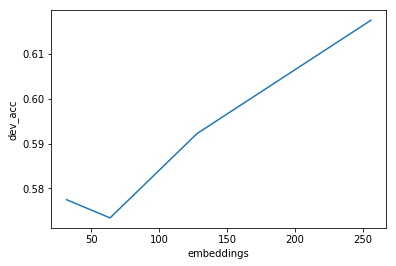

In [165]:
plot_metric_one_param(all_eval[all_eval['embeddings'] != 'Law2Vec'], 'embeddings', 'dev_acc')

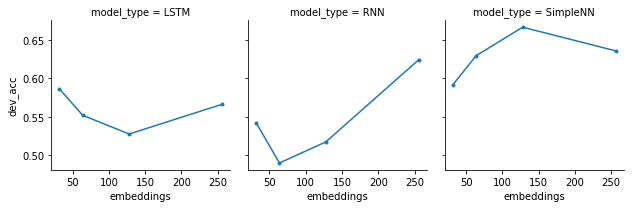

In [166]:
plot_metric_facet(all_eval[all_eval['embeddings'] != 'Law2Vec'], 'model_type', 'embeddings', 'dev_acc')

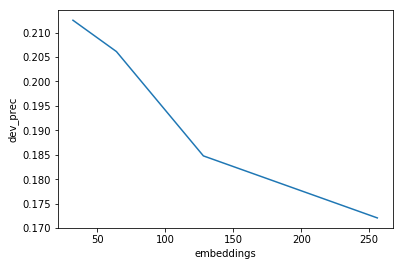

In [73]:
plot_metric_one_param(all_eval[all_eval['embeddings'] != 'Law2Vec'], 'embeddings', 'dev_prec')

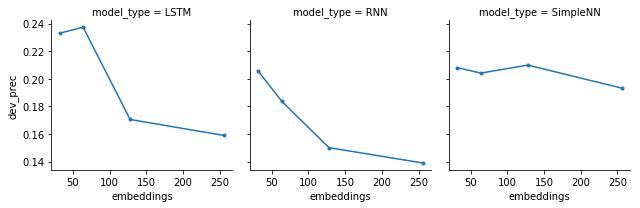

In [87]:
plot_metric_facet(all_eval[all_eval['embeddings'] != 'Law2Vec'], 'model_type', 'embeddings', 'dev_prec')

## Effect of varying hidden dimensions

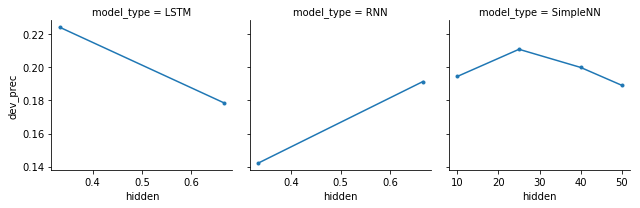

In [80]:
plot_metric_facet(all_eval, 'model_type', 'hidden', 'dev_prec')

## Effect of varying dropout rate

Increasing the dropout rate causes precision to decrease for LSTMs and increase for RNNs.

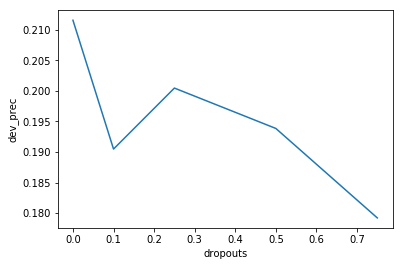

In [85]:
plot_metric_one_param(all_eval, 'dropouts', 'dev_prec')

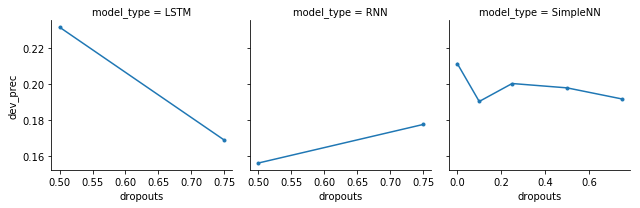

In [79]:
plot_metric_facet(all_eval, 'model_type', 'dropouts', 'dev_prec')

## Effect of varying learning rate

As learning rate increases, precision increases for RNNs, and increases even more markedly for LSTMs, but decreases for simple neural networks.

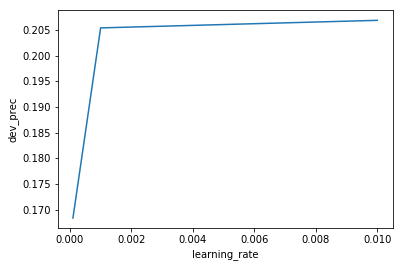

In [82]:
plot_metric_one_param(all_eval, 'learning_rate', 'dev_prec')

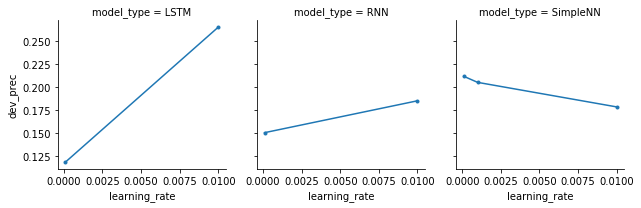

In [81]:
plot_metric_facet(all_eval, 'model_type', 'learning_rate', 'dev_prec')

## Difference in performance between pretrained and custom embeddings

From the following distributions, we see that custom embeddings produce higher accuracy and precision, but lower recall. 

In [88]:
pretrain = all_eval[all_eval['embeddings'] == 'Law2Vec']

In [91]:
custom = all_eval[all_eval['embeddings'] != 'Law2Vec']

In [99]:
pretrain[['dev_acc', 'dev_prec', 'dev_recall']].describe()

,dev_acc,dev_prec,dev_recall
count,372.000000,285.000000,372.000000
mean,0.462776,0.179760,0.585013
std,0.331353,0.131854,0.447031
min,0.135593,0.000000,0.000000
25%,0.135593,0.135593,0.125000
50%,0.288136,0.135593,0.875000
75%,0.864407,0.163265,1.000000
max,0.881356,1.000000,1.000000


In [100]:
custom[['dev_acc', 'dev_prec', 'dev_recall']].describe()

,dev_acc,dev_prec,dev_recall
count,1470.000000,1315.000000,1470.000000
mean,0.589819,0.193639,0.470153
std,0.274196,0.154813,0.387501
min,0.101695,0.000000,0.000000
25%,0.271186,0.135593,0.125000
50%,0.728814,0.160000,0.375000
75%,0.830508,0.226540,0.875000
max,0.881356,1.000000,1.000000


In [106]:
boxplots = all_eval.copy()
boxplots['embedding_type'] = np.where(boxplots['embeddings'] == 'Law2Vec', 'Pretrained', 'Custom')

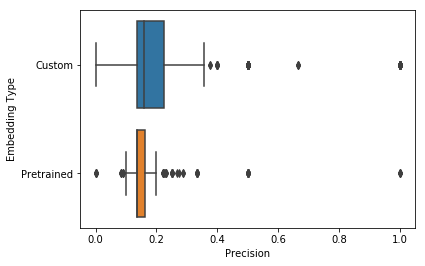

In [119]:
ax = sns.boxplot(x="dev_prec", y="embedding_type", data=boxplots)
ax.set(xlabel='Precision', ylabel='Embedding Type')
plt.show()

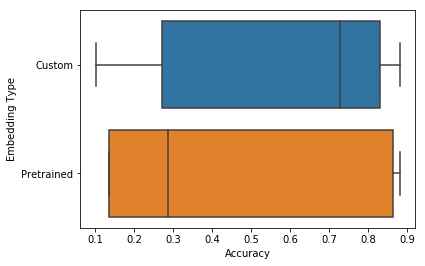

In [122]:
ax = sns.boxplot(x="dev_acc", y="embedding_type", data=boxplots)
ax.set(xlabel='Accuracy', ylabel='Embedding Type')
plt.show()

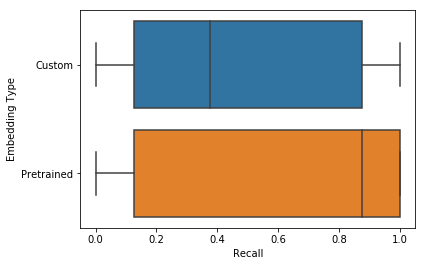

In [123]:
ax = sns.boxplot(x="dev_recall", y="embedding_type", data=boxplots)
ax.set(xlabel='Recall', ylabel='Embedding Type')
plt.show()

# Importing best models

In [124]:
models = {}
results_dir = '.'
for file in os.listdir(results_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.pt'):
        model_path = os.path.join(results_dir, filename)
        models[filename[:-3]] = torch.load(model_path)

In [125]:
models

{'SimpleNNCustom_best_rec': WordEmbAvg(
   (embedding): Embedding(32168, 32)
   (linear1): Linear(in_features=32, out_features=10, bias=True)
   (linear2): Linear(in_features=10, out_features=1, bias=True)
   (relu): ReLU()
   (drop_layer): Dropout(p=0, inplace=False)
 ),
 'SimpleNNCustom_best_prec': WordEmbAvg(
   (embedding): Embedding(32168, 32)
   (linear1): Linear(in_features=32, out_features=25, bias=True)
   (linear2): Linear(in_features=25, out_features=1, bias=True)
   (relu): ReLU()
   (drop_layer): Dropout(p=0.75, inplace=False)
 ),
 'SimpleNNLaw2Vec_best_rec': WordEmbAvgPtEmbeds(
   (embedding): Embedding(32168, 100)
   (linear1): Linear(in_features=100, out_features=10, bias=True)
   (linear2): Linear(in_features=10, out_features=1, bias=True)
   (relu): ReLU()
   (drop_layer): Dropout(p=0, inplace=False)
 ),
 'RNNCustom_best_acc': RNN(
   (embedding): Embedding(32168, 32, padding_idx=1)
   (rnn): RNN(32, 21, num_layers=2, dropout=0.75, bidirectional=True)
   (leakyrelu): 

## Running one model on test set

In [7]:
train_data, test_data, val_data, TEXT, LABEL = pre.get_data(
    'train_small.csv', 'val_small.csv', 'test_small.csv')

Connected!


../data_pipeline/preprocessing.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sans_nulls_df['alj_text'] = sans_nulls_df['alj_text'].str.slice(0, 1000000)


In [127]:
SEED = 1312
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

USE_CUDA = torch.cuda.is_available()

TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

BATCH_SIZE = 5

train_it, test_it, val_it = data.BucketIterator.splits(
    (train_data, test_data, val_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.alj_text),
    sort_within_batch=True,
    device = torch.device('cuda' if USE_CUDA else 'cpu'))

train_len = 0
train_pos = 0
for batch in train_it:
    train_len += len(batch.decision_binary)
    train_pos += batch.decision_binary.sum().item()
POS_WEIGHT = torch.tensor([(train_len - train_pos) / train_pos])
if USE_CUDA:
    POS_WEIGHT = POS_WEIGHT.cuda()
EPOCHS = 10

In [148]:
best_simple_model = models['SimpleNNCustom_best_prec']

In [168]:
best_simple_model

WordEmbAvg(
  (embedding): Embedding(32168, 32)
  (linear1): Linear(in_features=32, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (drop_layer): Dropout(p=0.75, inplace=False)
)

In [142]:
all_eval[(all_eval['metric'] == 'precision')]['dev_prec'].max()

1.0

In [143]:
all_eval[(all_eval['metric'] == 'precision') & (all_eval['dev_prec'] == 1)]

,Unnamed: 0,architecture,embeddings,hidden,dropouts,learning_rate,epochs,dev_acc,dev_prec,dev_recall,metric,model_type,num_layers,bidirectional
88,88,29,32,25.000000,0.75,0.0001,10,0.881356,1.0,0.125,precision,SimpleNN,NaN,NaN
991,91,30,32,0.666667,0.75,0.0100,10,0.881356,1.0,0.125,precision,RNN,2.0,True
994,94,31,32,0.666667,0.75,0.0001,10,0.881356,1.0,0.125,precision,RNN,2.0,True
1060,160,53,64,0.666667,0.75,0.0001,10,0.881356,1.0,0.125,precision,RNN,1.0,False
1111,211,70,128,0.333333,0.75,0.0100,10,0.881356,1.0,0.125,precision,RNN,1.0,True
1285,385,128,32,0.333333,0.50,0.0100,10,0.881356,1.0,0.125,precision,LSTM,1.0,False
1315,415,138,32,0.333333,0.50,0.0100,10,0.881356,1.0,0.125,precision,LSTM,2.0,True
1327,427,142,32,0.333333,0.75,0.0100,10,0.881356,1.0,0.125,precision,LSTM,2.0,True
1351,451,150,32,0.666667,0.75,0.0100,10,0.881356,1.0,0.125,precision,LSTM,1.0,True
1411,511,170,64,0.333333,0.50,0.0100,10,0.881356,1.0,0.125,precision,LSTM,2.0,True


In [149]:
tm = TrainingModule(best_simple_model, 0.01, POS_WEIGHT, USE_CUDA, EPOCHS)
tm.model = best_simple_model
test_loss, test_acc, test_prec, test_rec = tm.evaluate(test_it)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Rec: {test_rec*100:.2f}%')

Test Loss: 0.166 | Test Acc: 79.49% | Test Prec: 18.18% | Test Rec: 11.76%


## Words with highest norms

In [163]:
norms = torch.norm(best_simple_model.embedding.weight, p=2, dim=1, keepdim=True).data.squeeze()
highest_10 = norms.argsort()[-10:]

In [164]:
for i in highest_10:
    print(TEXT.vocab.itos[i])

cr02038
spectranetics
synthe
exhibits(2
deferred
occlusive
cr290
outreach
uncle
lost
